In [0]:
%tensorflow_version 2.x

In [10]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import shutil
import zipfile
from tqdm.notebook import tqdm
!pip install scikit-video==1.1.11
import skvideo.io
import tensorflow as tf

In [0]:
# Settings

# Путь к папке проекта
ROOT_DIR = os.path.abspath('.')
DATA_PATH = os.path.join(ROOT_DIR, "KTH_dataset")

links = [['walking', 'http://www.nada.kth.se/cvap/actions/walking.zip'],
        ['jogging', 'http://www.nada.kth.se/cvap/actions/jogging.zip'],
        ['running', 'http://www.nada.kth.se/cvap/actions/running.zip'],
        ['boxing', 'http://www.nada.kth.se/cvap/actions/boxing.zip'],
        ['handwaving', 'http://www.nada.kth.se/cvap/actions/handwaving.zip'],
        ['handclapping', 'http://www.nada.kth.se/cvap/actions/handclapping.zip']]

# Наименования классов
classes = ['walking', 'jogging', 'running',
          'boxing', 'handwaving', 'handclapping']

In [0]:
# Download and unzip dataset if not exists 
def get_data(links):
    for i in tqdm(range(len(links))):
        filepath = os.path.join(DATA_PATH, links[i][0] + '.zip')
        zip_path = os.path.join(DATA_PATH, links[i][0])
        if not os.path.exists(filepath):
            with urllib.request.urlopen(links[i][1]) as resp, open(filepath, 'wb') as out:
                print(f"Downloading {links[i][0]}.zip")
                shutil.copyfileobj(resp, out)
        if not os.path.exists(zip_path):
            with zipfile.ZipFile(filepath, 'r') as zip_ref:
                print(f"Unpacking {links[i][0]}.zip")
                zip_ref.extractall(zip_path)
    print("Done")
    
# Returns video files list
def get_filenames_list(classes):
    dataset = []
    for cls in classes:
        print('Processing class: {}'.format(cls))
        for fpath in glob.glob(os.path.join(DATA_PATH, cls, '*.avi')):
            cls_idx = classes.index(cls)
            dataset.append((fpath, cls_idx))
    print('Done')
    return dataset

In [14]:
get_data(links)
dataset = get_filenames_list(labels)

Unpacking walking.zip
Unpacking jogging.zip
Unpacking running.zip
Unpacking boxing.zip
Unpacking handwaving.zip
Unpacking handclapping.zip

Done
Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping
Done


### Подготовка датасета к классификации

In [23]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 180


### Визуализация кадра из видео

videodata shape: (390, 120, 160, 3)


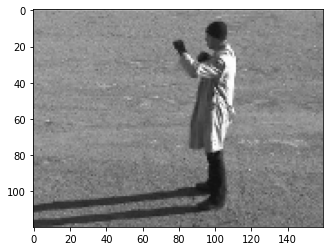

In [24]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

motion shape: (389, 120, 160, 1)


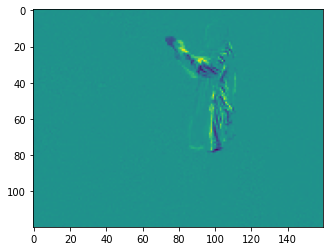

In [25]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])


In [27]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 389, 120, 160, 1)
Output shape: (1, 6)


In [0]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

In [29]:
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/10][0/180] Loss = 1.7979464530944824
[0/10][10/180] Loss = 1.7917428016662598
[0/10][20/180] Loss = 1.7857745885849
[0/10][30/180] Loss = 1.7894381284713745
[0/10][40/180] Loss = 1.7570512294769287
[0/10][50/180] Loss = 1.7356786727905273
[0/10][60/180] Loss = 1.7379432916641235
[0/10][70/180] Loss = 1.8524574041366577
[0/10][80/180] Loss = 1.857339859008789
[0/10][90/180] Loss = 1.798426628112793
[0/10][100/180] Loss = 1.7976137399673462
[0/10][110/180] Loss = 1.6899964809417725
[0/10][120/180] Loss = 1.8683314323425293
[0/10][130/180] Loss = 1.8549021482467651
[0/10][140/180] Loss = 1.8035216331481934
[0/10][150/180] Loss = 1.8565846681594849
[0/10][160/180] Loss = 1.7733573913574219
[0/10][170/180] Loss = 1.7888388633728027
[1/10][0/180] Loss = 1.7572286128997803
[1/10][10/180] Loss = 1.7921489477157593
[1/10][20/180] Loss = 1.8227410316467285
[1/10][30/180] Loss = 1.8262889385223389
[1/10][40/180] Loss = 1.6967601776123047
[1/10][50/180] Loss = 1.960267424583435
[1/10][60/180] L

## Тестирование обученной модели

True class: jogging
Predicted class: jogging


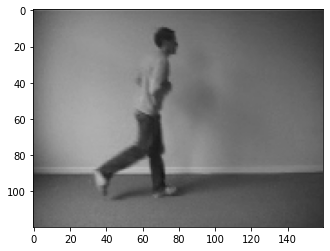

In [101]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])

True class: boxing
Predicted class: handwaving
Пока махал руками успел сделать несколько подходов


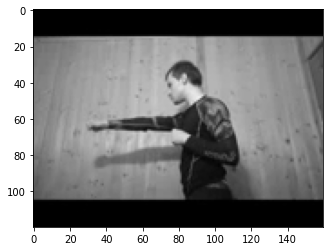

In [123]:
# fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread('./test-boxing-g.mp4')
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[115, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', 'boxing')
print('Predicted class:', classes[cls_pred])
print('Пока махал руками успел сделать несколько подходов')

Вывод: Для корректного обучения важно соблюдать размерность тестовых данных - после конвертирования и обесцвечивания изображения модель стала точнее распознавать движения

In [0]:
"""======================================"""
"""Код для записи видео в opencv"""


import cv2

# Инициализация захвата видео
video_capture = cv2.VideoCapture(0) # 0 = фронтальная камера

# Инициализация записи в файл, MJPG кодек для avi формата (также подойдет *XVID)
video_writer = cv2.VideoWriter('./test_boxing.avi', cv2.VideoWriter_fourcc(*"MJPG"), 20.0, (int(video_capture.get(3)), int(video_capture.get(4))))


# Эдакий тайминг отложенной съемки
time.sleep(2)
i = 0
frames = 300 # кол-во кадров

while i < frames:
    success, frame = video_capture.read()
    
    cv2.imshow('Video', frame)
    video_writer.write(frame)
        
    # При нажатии 'q' завершает исполнение кода 
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    i+=1

# Завершает работу устройств вывода и записи, закрывает окно видео
video_capture.release()
video_writer.release()
cv2.destroyAllWindows()